In [1]:
from jupyterthemes import jtplot
jtplot.style(theme='monokai') 
import numpy as np
import pandas as pd
from sklearn import svm

In [2]:
train = pd.read_csv("./train_crown_features.csv")
test = pd.read_csv("./test_crown_features.csv")
print(train.describe())

         train_id      mean_h  crown_area  crown_perim         dbh
count  100.000000  100.000000   100.00000   100.000000  100.000000
mean    50.500000   25.116951    22.13120    25.992000   40.280000
std     29.011492    6.062526    12.88846     9.234451   13.447301
min      1.000000   14.525690     2.08000     1.600000   14.500000
25%     25.750000   20.403993    12.28000    20.800000   29.875000
50%     50.500000   23.497401    20.16000    26.400000   41.000000
75%     75.250000   29.329508    29.48000    32.800000   51.875000
max    100.000000   40.867333    65.44000    45.600000   63.500000


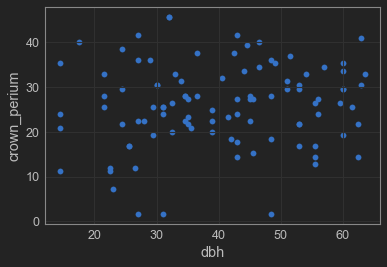

In [3]:
import matplotlib.pyplot as plt
x = train["dbh"]
y = train["crown_perim"]
plt.scatter(x,y)
plt.xlabel("dbh")
plt.ylabel("crown_perium")
plt.show()

In [4]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV

target = train["dbh"]
train = train.drop(["dbh", "train_id"],axis=1)
test_target = test["test_id"]
test = test.drop(["test_id"],axis=1)

In [5]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

kf = KFold(n_splits=100,random_state=0)
param = {
        "max_depth": 3,
        "eta": 0.01,
        "objective": "reg:squarederror",
    }
num_round = 250

results = []
dist = []
for X_index, Y_index in kf.split(train):
    X_train, X_target = train.loc[X_index], target.loc[X_index]
    Y_train, Y_target = train.loc[Y_index], target.loc[Y_index]
    
    dtrain = xgb.DMatrix(pd.DataFrame(X_train), label=pd.DataFrame(X_target))
    dvalid = xgb.DMatrix(pd.DataFrame(Y_train), label=pd.DataFrame(Y_target))
    
    bst = xgb.train(
                            param, dtrain,
                            num_round,
    )
    pred = bst.predict(dvalid)
    results.append(np.sqrt(mean_squared_error(Y_target,pred)))
    dist.append((pred-Y_target).values)
print(np.array(results).mean())

C:\Users\owner\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


11.722924842834473


[ 6.69060135 18.00528336  0.48962021  0.96275711 35.46493149 31.05584526
 13.29605484  9.65041733 13.55461502 23.7599678  17.92453384 22.45075989
 17.33703995 15.87986374 24.71197891  3.10528183  0.80340195  8.2737236
  1.15874481  3.19494247  7.90732193 22.1530571   7.43123055 13.96419525
 22.2218132  28.13499451  8.63031769  9.28186417 15.92675781 23.87569427
 13.90303421 17.43502808  0.80340195  1.37099457 14.73783493 13.8146286
 22.03635406  9.4969368  21.90550995  2.44129181 24.30239868  0.7165451
 12.1888237   3.5268631   7.22603607 18.47170639 12.17329407 15.54154205
  2.31326294  7.67980576 19.39968872 12.04011917 22.18646622 24.45828056
  9.74062729 25.09753036  1.48820877 21.44703674  4.06512642  9.03824997
  1.64947891 11.23211288  1.64230728 13.12474823 11.35027695 15.65560913
 18.86468124 25.61956406 16.28195953 10.01873398  1.20658684  2.6155777
 20.96347046  1.91143417 18.42105103  6.6117897  11.04475403 10.06815338
 10.61968613 11.58393478  5.10591125 11.89904404  9.768

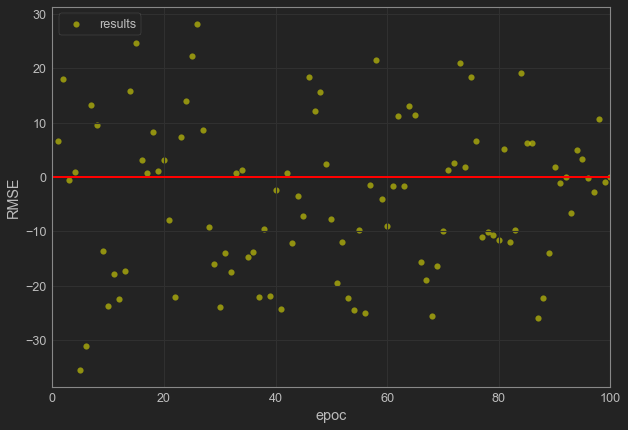

In [6]:
print(np.array(results))
dists = np.array(dist)
plt.figure(figsize = (10, 7))
plt.scatter(range(1,101), dist, c = 'yellow', marker = 'o', s = 35, alpha = 0.5, label = 'results')
plt.xlabel('epoc')
plt.ylabel('RMSE')
plt.legend(loc = 'upper left')
plt.hlines(y = 0, xmin = 0, xmax = 100, lw = 2, color = 'red')
plt.xlim([0, 100])
plt.show()

In [29]:
dtest = xgb.DMatrix(test)
pred = pd.DataFrame()
pred["Id"] = test_target
pred["dbh"] = (bst.predict(dtest)).round(2)
pred.to_csv("DBH_xgb_loo2.csv", index=False)